In [1]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt


3000
400


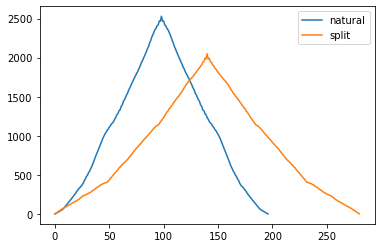

In [2]:
seq1 = "112121212323232323234232234544545455765656565545344343565656565656565657676676767687878788776565664"
seq1 = [int(x) for x in seq1]

seq2 = "121221221212121221212122222111121222122212212121234434343344434333344443434343434343434343434343565656565656565656565665655555555555656656565"
seq2 = [int(x) for x in seq2]

plt.plot(signal.correlate(seq1, seq1, mode='full', method='auto'), label="natural")
plt.plot(signal.correlate(seq2, seq2, mode='full', method='auto'), label="split")
plt.legend()
plt.show()

# Ultrametric tree

In [59]:
# fixed values
L_const = 8
# j_range = 0,1,...,2**(L-1)-1 = 2^7-1 = 127
# l_range = 2,3,...,L = 8

# initial__local_state j + 1 + 2*sign(entier(j/2) - j/2)
# final_state j

# dim of R_l, P_l, id_l is (2^l * 2^l)

def R_mat(j,l):
    res = [[R_mat(2*j, l-1) - r(2*j+1, l) + np.identity(l-1), r(2*j+1, l)*P_mat(2*j+1,l-1)],
           [r(2*j, l)*P(2*j, l-1),R_mat(2*j+1, l-1) - r(2*j, l)*np.identity(l-1)]]
    print("R_mat_out: ", res)
    return res

#R_start
def R_mat_1(j):
    res = [[-r(2*j+1, 1), r(2*j+1, l)],
            [r(2*j, l), -r(2*j, l)]]
    print("R_mat_1_out: ", res)
    return res

def P_mat(j, l):
    res = np.transpose([p0(j, l).T] * 2**l)
    print("P_mat_out: ", res)
    return res
    
def p0(j, l):
    #print("l: ", l)
    if l == 1:
        res = [p(2*j, 1), p(2*j+1, 1)]
    else:
        res = [p(2*j, l)*p0(2*j, l-1), p(2*j+1, l)*p0(2*j, l-1)]
    
    res = np.array(res).flatten()
    #print("p0_out: ", res)
    return res

def p(j_times_2, l):
    if j_times_2 % 2:
        res = 1 - p(j_times_2-1, l)
    else:
        res = r(j_times_2, l) / (r(j_times_2, l) + r(j_times_2+1, l))
    
    #print("p_out: ", res)
    return res

def r(j, l):
    return 0.5
    #return 1/(j+L_const-l+1e-5)
                                                        

In [60]:
# Utils (optional)

#entier is largest int contained in cluster x
def entier(x):
    return np.max(x)

In [61]:
# Questions
## 1) Define r = 1/L ??


In [62]:
# Solution
## Conditional proba of being at state n after time t
def c0(n, t):
    res = np.sum([c_0(l, n)*np.exp(t*R_eval(l,0)) for l in range(2, L_const+1)])
    print("c0_proba_out: ", res)
    return res

def c_0(l, n):
    print("l_inter: ", l)
    #equ: c^l_0,n = (~p^L_l,0)_0 * (p^L_l,0)_n
    #res = np.ones(L_const)*p(l,0)
    #def p(L,j,l): return [np.zeros((l-1, int(l/2)-1)), p(2*j, l-1), p(2*j+1, l-1), np.zeros((l-1, int(l/2)-1))]
    def p_T(j,l): 
        middle_block = np.concatenate((-p(2*j+1, l)*np.ones(2**(l-1)), p(2*j, l)*np.ones(2**(l-1))), axis=0)
        right_zeros = np.tile(np.zeros(2**(l-1)), max(2**(L_const-l-1)-2*j-3, 0))
        res = np.concatenate((middle_block, right_zeros), axis=0)
        
        if j > 0:
            left_zeros = np.tile(np.zeros(2**(l-1)), max(2*j-1, 0))
            res = np.concatenate((left_zeros, res), axis=0)

        return res # 1D array
    
    p_T_0_0 = p0(0, L_const)
    print('p_T_0_0 ', p_T_0_0.shape)
    print('p_T(0,L_const) ', p_T(0,L_const).shape)
    D_mat = np.array([p_T_0_0, p_T(0,L_const)])
    for j in range(1, 2**(L_const-1)-1):
        l=1
        #for l in range(1, L_const-1):  # doing this for loop does not yield the correct dimensions ? 
        print(p_T(j-1,L_const-l).shape, p_T(j,L_const-l).shape)
        addition_2 = np.stack((p_T(j-1,L_const-l), p_T(j,L_const-l)))
        print("aaa ", addition_2.shape, "  ", D_mat.shape)
        print("bbb ", addition_2)
        D_mat = np.concatenate((D_mat, addition_2), axis=0)
            
    print("D_mat: ", D_mat.shape)
    D_inv = np.linalg.inv(D_mat)
        
    #res = p0_tilde(0, l)[0] * p0(0, l)[n-1] 
    res = D_inv[L_const-l][0] * D_mat[L_const-l][n-1]
    print("p0_res_size: ", res.shape, res)
    print("n-1", n-1)
    print("c_0_out: ", res)
    return res

def R_eval(j, l):
    if l == j == 0:
        res = 0
    elif l == L_const and j == 0:
        res = -r(0, L_const) - r(1, L_const)
    else:
        res = -r(2*j, l) - r(2*j+1, l) - np.sum(
            [r(int(j/(2**(l_prime-l-1))), l_prime) for l_prime in range(l+1, L_const+1)])
        
    print("R_eval_out: ", res)
    return res
    

In [63]:
c0(3,1)

l_inter:  2
p_T_0_0  (256,)
p_T(0,L_const)  (256,)
(128,) (192,)


ValueError: all input arrays must have the same shape

## Markov matrix